### ARIMA model
*In case you need to restart, run each cell one by one making sure to turn off each matplotlib decorator.

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
from numpy import log
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

The purpose of this analysis is to predict the price of tomato (saladette, the red one..) in Mexico City, which is one of the most consumed products locally and is also exported overseas. The model used for this time series prediction is ARIMA since the data we have is a time series.
<p>This dataset contains the monthly average prices of basic food products for Mexico from jaunary 2011 to july 2018, gathered  by INEGI from publishments on the Official Federation Journal. Total observations are 91, this is important since ARIMA model, according to Box and Jenkins, requires a minimum of 50.  

#### Reading and preparing the data

In [2]:
#Read files
df = pd.read_csv('INEGI alimentos/ago16-jul18.CSV', encoding = 'latin1')
df2 = pd.read_csv('INEGI alimentos/ago14-jul16.CSV', encoding = 'latin1')
df3 = pd.read_csv('INEGI alimentos/ago12-jul14.CSV', encoding = 'latin1')
df4 = pd.read_csv('INEGI alimentos/ene11-jul12.CSV', encoding = 'latin1')

In [3]:
#Verify the columns from four files are the same in order to concatenate them
all(df.columns == df2.columns) 

True

In [4]:
all(df3.columns == df2.columns)

True

In [5]:
all(df3.columns == df4.columns) 

True

In [6]:
#Concatenate all files
data = pd.concat([df4,df3, df2, df])
data.head()

,Año,Mes,Fecha_Pub_DOF,Clave ciudad,Nombre ciudad,División,Grupo,Clase,Subclase,Clave generico,Generico,Consecutivo,Especificación,Precio promedio,Cantidad,Unidad,Estatus
0,2012,7,20/08/2012 12:00:00 a. m.,1,Área Met. de la Cd. de México,"1. Alimentos, bebidas y tabaco",1.1. Alimentos,"1.1.1. Pan, tortillas y cereales",01 Tortillas y derivados del maíz,1,Tortilla de maíz,1,"TORTILLAS, A GRANEL",11.0,1,KG,NaN
1,2012,7,20/08/2012 12:00:00 a. m.,1,Área Met. de la Cd. de México,"1. Alimentos, bebidas y tabaco",1.1. Alimentos,"1.1.1. Pan, tortillas y cereales",01 Tortillas y derivados del maíz,1,Tortilla de maíz,2,"TORTILLAS, A GRANEL",10.9,1,KG,NaN
2,2012,7,20/08/2012 12:00:00 a. m.,1,Área Met. de la Cd. de México,"1. Alimentos, bebidas y tabaco",1.1. Alimentos,"1.1.1. Pan, tortillas y cereales",01 Tortillas y derivados del maíz,1,Tortilla de maíz,3,"TORTILLAS, A GRANEL",11.0,1,KG,NaN
3,2012,7,20/08/2012 12:00:00 a. m.,1,Área Met. de la Cd. de México,"1. Alimentos, bebidas y tabaco",1.1. Alimentos,"1.1.1. Pan, tortillas y cereales",01 Tortillas y derivados del maíz,1,Tortilla de maíz,4,"TORTILLAS, A GRANEL",11.0,1,KG,NaN
4,2012,7,20/08/2012 12:00:00 a. m.,1,Área Met. de la Cd. de México,"1. Alimentos, bebidas y tabaco",1.1. Alimentos,"1.1.1. Pan, tortillas y cereales",01 Tortillas y derivados del maíz,1,Tortilla de maíz,5,"TORTILLAS, A GRANEL",12.0,1,KG,NaN


In [7]:
#Look at unique values per column
for column in data:
    print(column)
    print(data[column].unique())

Año
[2012 2011 2014 2013 2016 2015 2018 2017]
Mes
[ 7  6  5  4  3  2  1 12 11 10  9  8]
Fecha_Pub_DOF
['20/08/2012 12:00:00 a. m.' '23/07/2012 12:00:00 a. m.'
 '22/06/2012 12:00:00 a. m.' '24/05/2012 12:00:00 a. m.'
 '26/04/2012 12:00:00 a. m.' '26/03/2012 12:00:00 a. m.'
 '27/02/2012 12:00:00 a. m.' '23/01/2012 12:00:00 a. m.'
 '22/12/2011 12:00:00 a. m.' '24/11/2011 12:00:00 a. m.'
 '21/10/2011 12:00:00 a. m.' '27/09/2011 12:00:00 a. m.'
 '26/08/2011 12:00:00 a. m.' '22/07/2011 12:00:00 a. m.'
 '23/06/2011 12:00:00 a. m.' '26/05/2011 12:00:00 a. m.'
 '28/04/2011 12:00:00 a. m.' '01/04/2011 12:00:00 a. m.'
 '04/03/2011 12:00:00 a. m.' '28/08/2014 12:00:00 a. m.'
 '21/07/2014 12:00:00 a. m.' '20/06/2014 12:00:00 a. m.'
 '26/05/2014 12:00:00 a. m.' '24/04/2014 12:00:00 a. m.'
 '21/03/2014 12:00:00 a. m.' '24/02/2014 12:00:00 a. m.'
 '20/01/2014 12:00:00 a. m.' '20/12/2013 12:00:00 a. m.'
 '15/11/2013 12:00:00 a. m.' '21/10/2013 12:00:00 a. m.'
 '27/09/2013 12:00:00 a. m.' '19/08/2013 12

In [8]:
#Select only the columns we need
data = data[['Año', 'Mes', 'Clave ciudad', 'Nombre ciudad','Generico', 'Especificación','Precio promedio', 'Unidad']]

In [9]:
data.head()

,Año,Mes,Clave ciudad,Nombre ciudad,Generico,Especificación,Precio promedio,Unidad
0,2012,7,1,Área Met. de la Cd. de México,Tortilla de maíz,"TORTILLAS, A GRANEL",11.0,KG
1,2012,7,1,Área Met. de la Cd. de México,Tortilla de maíz,"TORTILLAS, A GRANEL",10.9,KG
2,2012,7,1,Área Met. de la Cd. de México,Tortilla de maíz,"TORTILLAS, A GRANEL",11.0,KG
3,2012,7,1,Área Met. de la Cd. de México,Tortilla de maíz,"TORTILLAS, A GRANEL",11.0,KG
4,2012,7,1,Área Met. de la Cd. de México,Tortilla de maíz,"TORTILLAS, A GRANEL",12.0,KG


In [10]:
#Add column for Date concatenating year and month
data.insert(0, 'Mes-Año', data['Mes'].map(str) + '-' + data['Año'].map(str))

In [11]:
#Make the new column into datetime format
data.loc[:,'Mes-Año'] = pd.to_datetime(data.loc[:,'Mes-Año'])

In [12]:
#Check the datetimes included in our new column
data['Mes-Año'].unique()

array(['2012-07-01T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
       '2012-05-01T00:00:00.000000000', '2012-04-01T00:00:00.000000000',
       '2012-03-01T00:00:00.000000000', '2012-02-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2011-12-01T00:00:00.000000000',
       '2011-11-01T00:00:00.000000000', '2011-10-01T00:00:00.000000000',
       '2011-09-01T00:00:00.000000000', '2011-08-01T00:00:00.000000000',
       '2011-07-01T00:00:00.000000000', '2011-06-01T00:00:00.000000000',
       '2011-05-01T00:00:00.000000000', '2011-04-01T00:00:00.000000000',
       '2011-03-01T00:00:00.000000000', '2011-02-01T00:00:00.000000000',
       '2011-01-01T00:00:00.000000000', '2014-07-01T00:00:00.000000000',
       '2014-06-01T00:00:00.000000000', '2014-05-01T00:00:00.000000000',
       '2014-04-01T00:00:00.000000000', '2014-03-01T00:00:00.000000000',
       '2014-02-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '2013-12-01T00:00:00.000000000', '2013-11-01

In [13]:
#Sort data by increasing date
data = data.sort_values(by=['Mes-Año'])

In [14]:
# Check for missing values in the dataframe
data.isnull().values.any()

False

### Mexico City Dataframe

In [15]:
#Create a new dataframe filtering only Mexico City
datacdmx = data[data['Clave ciudad'] == 1]
datacdmx.head()

,Mes-Año,Año,Mes,Clave ciudad,Nombre ciudad,Generico,Especificación,Precio promedio,Unidad
149737,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",15.00,KG
149738,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",17.50,KG
149739,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",13.95,KG
149740,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",13.50,KG
149741,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",14.31,KG


#### Make a dataset for Jitomate Saladette

In [16]:
saladette = datacdmx[datacdmx['Especificación']=='SALADETTE, A GRANEL']

In [17]:
saladette.head()

,Mes-Año,Año,Mes,Clave ciudad,Nombre ciudad,Generico,Especificación,Precio promedio,Unidad
149737,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",15.00,KG
149738,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",17.50,KG
149739,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",13.95,KG
149740,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",13.50,KG
149741,2011-01-01,2011,1,1,Área Met. de la Cd. de México,Jitomate,"SALADETTE, A GRANEL",14.31,KG


##### Get the average price per product per month

In [18]:
#Obtain an average price per month including units
avg = saladette.groupby(['Mes-Año', 'Generico', 'Unidad'])
a = avg['Precio promedio'].mean()
a

Mes-Año     Generico  Unidad
2011-01-01  Jitomate  KG        14.742642
2011-02-01  Jitomate  KG        17.337170
2011-03-01  Jitomate  KG        15.443774
2011-04-01  Jitomate  KG        26.209623
2011-05-01  Jitomate  KG        15.720566
2011-06-01  Jitomate  KG        10.543396
2011-07-01  Jitomate  KG        12.083208
2011-08-01  Jitomate  KG        11.316981
2011-09-01  Jitomate  KG        11.861698
2011-10-01  Jitomate  KG        11.275283
2011-11-01  Jitomate  KG        10.462075
2011-12-01  Jitomate  KG        12.750000
2012-01-01  Jitomate  KG        13.402830
2012-02-01  Jitomate  KG         9.260377
2012-03-01  Jitomate  KG        10.475094
2012-04-01  Jitomate  KG         9.916226
2012-05-01  Jitomate  KG        10.632075
2012-06-01  Jitomate  KG        15.258679
2012-07-01  Jitomate  KG        15.764528
2012-08-01  Jitomate  KG        13.552642
2012-09-01  Jitomate  KG        16.660566
2012-10-01  Jitomate  KG        16.862075
2012-11-01  Jitomate  KG        13.268302
2012-

In [19]:
a.shape

(91,)

In [20]:
#Dataset to use comprising Ciudad de Mexico and Jitomate saladette
d = pd.DataFrame(a)
d.reset_index(inplace=True)
d.head()

,Mes-Año,Generico,Unidad,Precio promedio
0,2011-01-01,Jitomate,KG,14.742642
1,2011-02-01,Jitomate,KG,17.337170
2,2011-03-01,Jitomate,KG,15.443774
3,2011-04-01,Jitomate,KG,26.209623
4,2011-05-01,Jitomate,KG,15.720566


#### Export dataframe into a csv file 

In [21]:
#d.to_csv('Jitomate_Saladette.csv', index=False, encoding="latin1")

Since a time series requires full periods for the trainment, we are going delete 2018 since we do not have the full year but only till july.

In [22]:
#Delete 2018
d17 = d.drop(d[d['Mes-Año'] >= '2018-01-01'].index)
d17.tail()

,Mes-Año,Generico,Unidad,Precio promedio
79,2017-08-01,Jitomate,KG,29.307963
80,2017-09-01,Jitomate,KG,22.966111
81,2017-10-01,Jitomate,KG,16.178889
82,2017-11-01,Jitomate,KG,17.894074
83,2017-12-01,Jitomate,KG,26.784630


In [23]:
#Checking units
d17['Generico'].value_counts()

Jitomate    84
Name: Generico, dtype: int64

### Jitomate - (train 2011-2015, test 2016-2017)

Train dataset will comprise years 2011 to 2015 (60 months) and Test dataset will comprise years 2016 and 2017 (24 months) for tomato price

In [24]:
#Series for tomato
jitomatep = d17['Precio promedio']

train_jitomate = jitomatep[0:60]
test_jitomate = jitomatep[60:84]

In [25]:
jitomatep.shape

(84,)

In [26]:
#Series for time
time = d17['Mes-Año']
time = time.astype('str')
time = time.tolist()

train_time = time[0:60]
test_time = time[60:84]

#### Stationality and Tendency check - Line plot

<IPython.core.display.Javascript object>


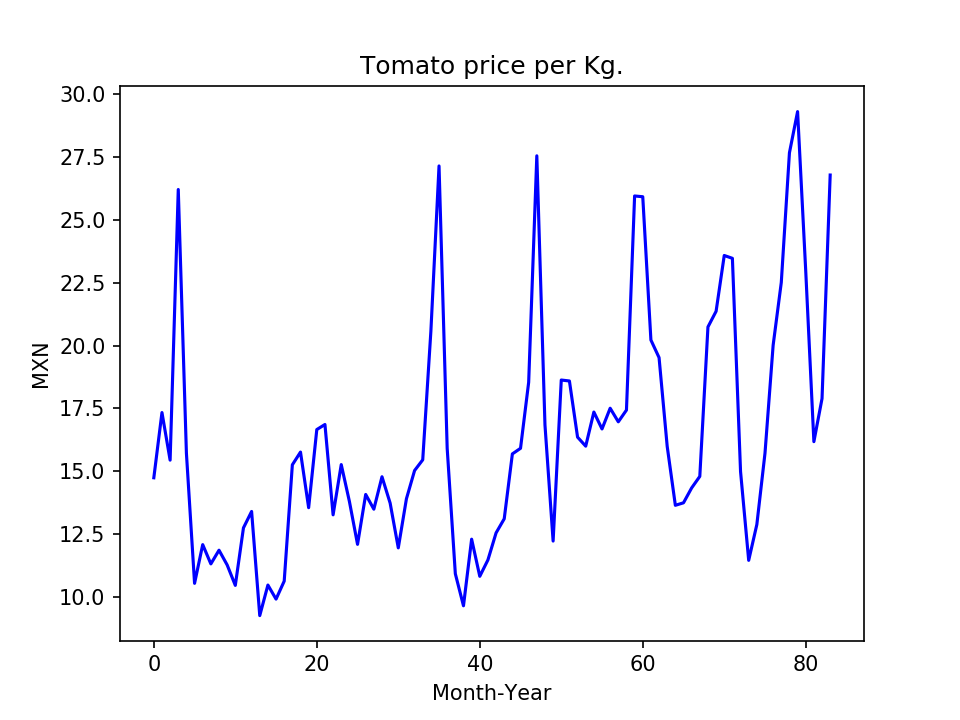

Text(0, 0.5, 'MXN')

In [27]:
%matplotlib notebook
plt.plot(jitomatep, color="blue", label="Tomato")
plt.title("Tomato price per Kg.")
plt.xlabel("Month-Year")
plt.ylabel("MXN")

The behavior shows slight tendency to increase. As per stationality, it seems to be stationary however we must conduct some other tests.

#### Stationality check - Variance and Mean of split series

In [28]:
split = int(len(train_jitomate) / 2)
X1 = train_jitomate[0:split]
X2 = train_jitomate[split:]

In [29]:
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=13.735157, mean2=16.302532
variance1=10.441142, variance2=20.241591


Since the means and variance vary for the first and second half of the period, most likely the series is not stationary.

#### Histogram

<IPython.core.display.Javascript object>


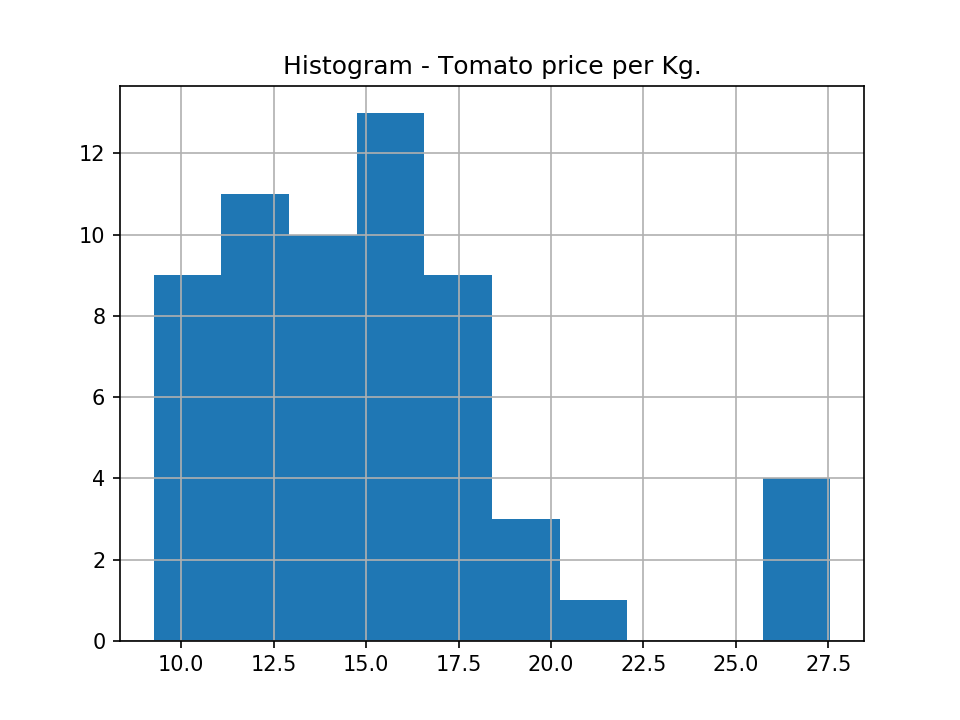

In [30]:
train_jitomate.hist()
plt.title("Histogram - Tomato price per Kg.")
plt.show()

We can note that most of the prices througuout the years fall in the range of 10MXN to 18MXN.

#### Stationality check - Dickey Fuller Test

Null Hypothesis (h0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary.

Alternate Hypothesis (h1): If the null hypothesis is rejected, it suggests the time series does not have a unit root (does not have time-dependent structure), meaning it is stationary.

p-value > 0.05: Fail to reject the null hypothesis (h0), the data has a unit root and is non-stationary.
<br>p-value <= 0.05: Reject the null hypothesis (h0), the data does not have a unit root and is stationary.

In [31]:
result = adfuller(train_jitomate)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.553488
p-value: 0.102996
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595


These values show that the h0 cannot be rejected, therefore the series is non-stationary. Let's perform a log transformation to see if it can turn into stationary.

#### 1. Apply logaritmic transformation

In [32]:
#Log transformation
log_train_jitomate = log(train_jitomate)

#Dickey Fuller test
result2 = adfuller(log_train_jitomate)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.078145
p-value: 0.028213
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595


In [33]:
#Check mean and variance of split data
split = int(len(log_train_jitomate) / 2)
X1 = log_train_jitomate[0:split]
X2 = log_train_jitomate[split:]

In [34]:
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2.596987, mean2=2.757436
variance1=0.044915, variance2=0.068200


<IPython.core.display.Javascript object>


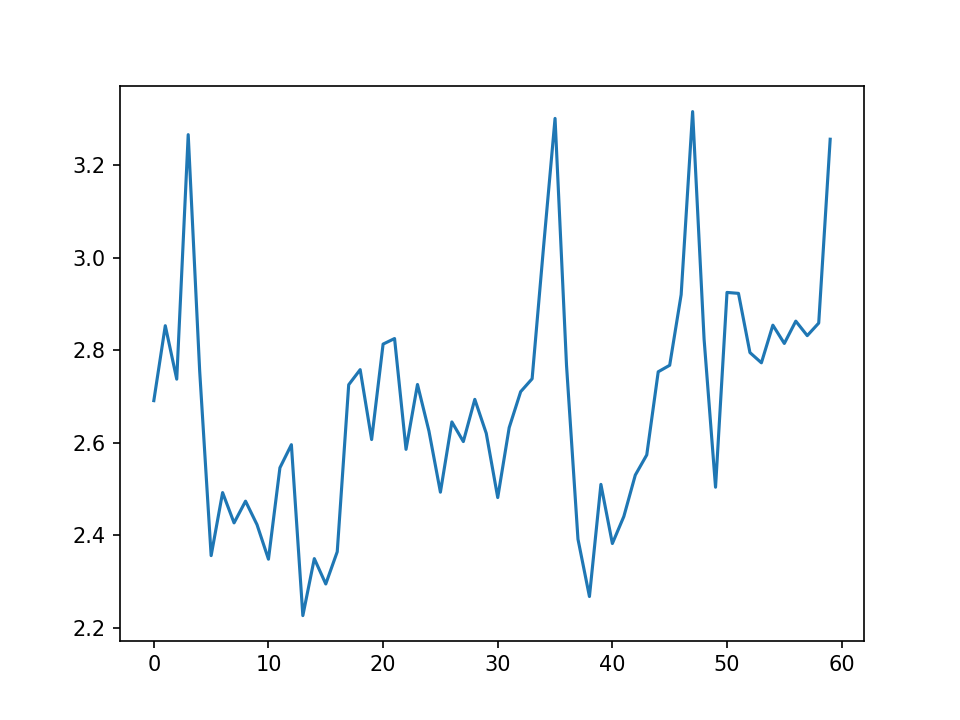

In [35]:
plt.plot(log_train_jitomate)
plt.show()

P-value reduced after applying logarithmic function and now it is possible to reject h0 and consider this series stationary plus the mean and variance of both halves of the series are similar. Still let us try differencing the data to see if we can obtain better results.

#### 2. Differentiate data

<IPython.core.display.Javascript object>


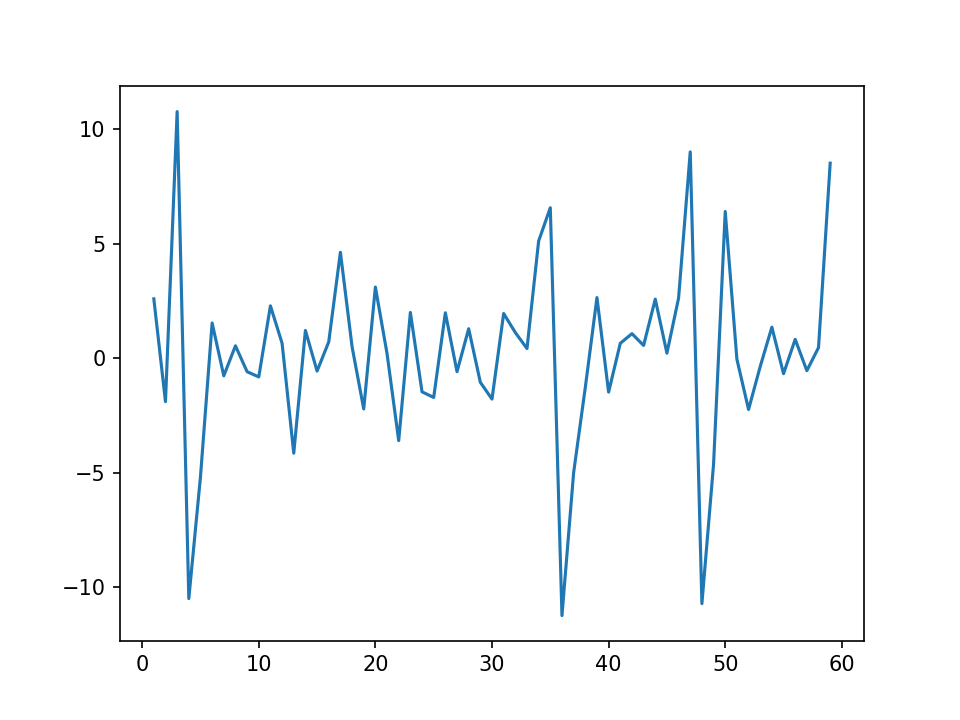

In [36]:
diff_train_jitomate = train_jitomate.diff()
diff_train_jitomate = diff_train_jitomate[1:]
plt.plot(diff_train_jitomate)
plt.show()

In [38]:
#Dickey Fuller test
result = adfuller(diff_train_jitomate)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -7.761957
p-value: 0.000000
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595


In [39]:
#Check mean and variance of split data
split = int(len(diff_train_jitomate) / 2)
X1 = diff_train_jitomate[0:split]
X2 = diff_train_jitomate[split:]

In [40]:
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=-0.034756, mean2=0.407225
variance1=12.773591, variance2=20.326043


After one order of differencing, the ADF statistic increased and p-value is low enough to reject h0 and hence consider this dataset stationary.This transformation gives a better p-value however the mean and variance are more apart in both halves of the data.

In [41]:
#Mean of the differentiated data
diff_train_jitomate.mean()

0.18998033850928

In [42]:
#Variance of the differentiated data
diff_train_jitomate.var()

16.379246878160533

##### ACF (Auto Correlation Finction) and PACF (Partial Auto Correlation Function ) for differentiated data

ACF and PACF will allow us define the values q and p for the ARIMA model. Since we differentiated the data once, value d is equal to 1.

<IPython.core.display.Javascript object>


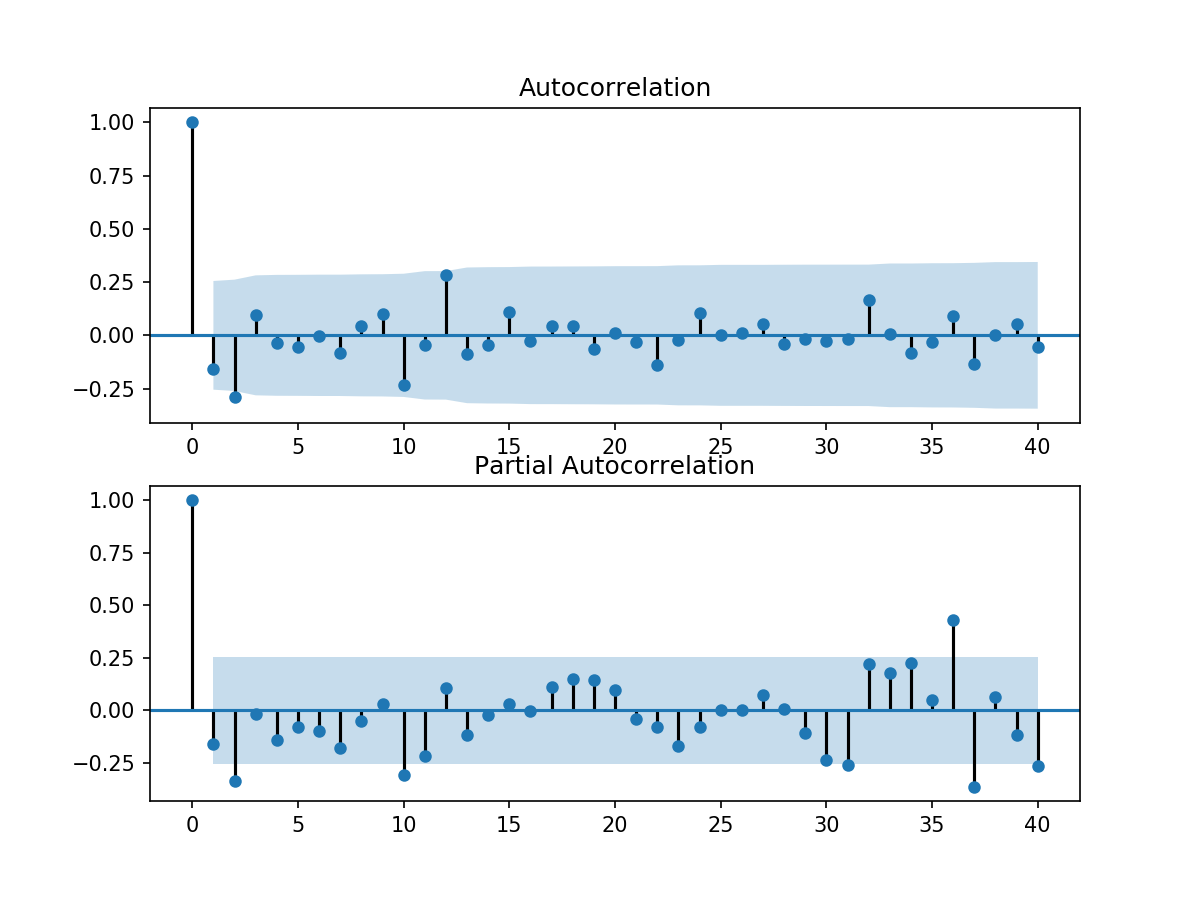

In [43]:
acf(diff_train_jitomate)
plt.show()

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_train_jitomate, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_train_jitomate, lags=40, ax=ax2)

plt.savefig('ACF_PACF_diff.png')

##### ACF (Auto Correlation Finction) and PACF (Partial Auto Correlation Function ) for logarithmic data

<IPython.core.display.Javascript object>


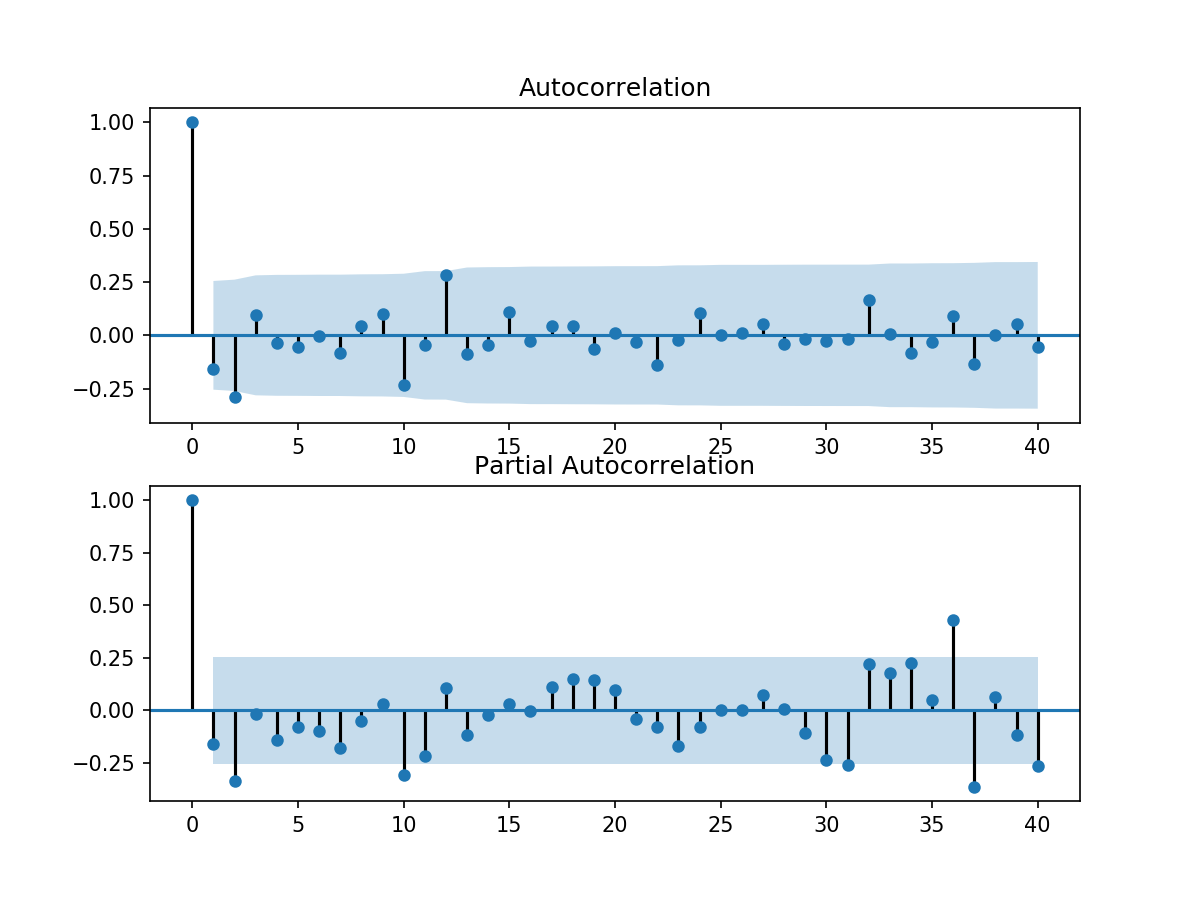

In [44]:
acf(log_train_jitomate)
plt.show()

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_train_jitomate, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_train_jitomate, lags=40, ax=ax2)

We can see that the ACF and PACF plots are practically the same for both transformations. Autocorrelation is significant at lags 1 and 3 as per partial correlation is significant at lag 1,3,11 and close to the 36 and 37 lag. It is important to note that first lag is always significant since it tests correlation of the observation itself.

#### Autocorrelation plot of differentiated data

<IPython.core.display.Javascript object>


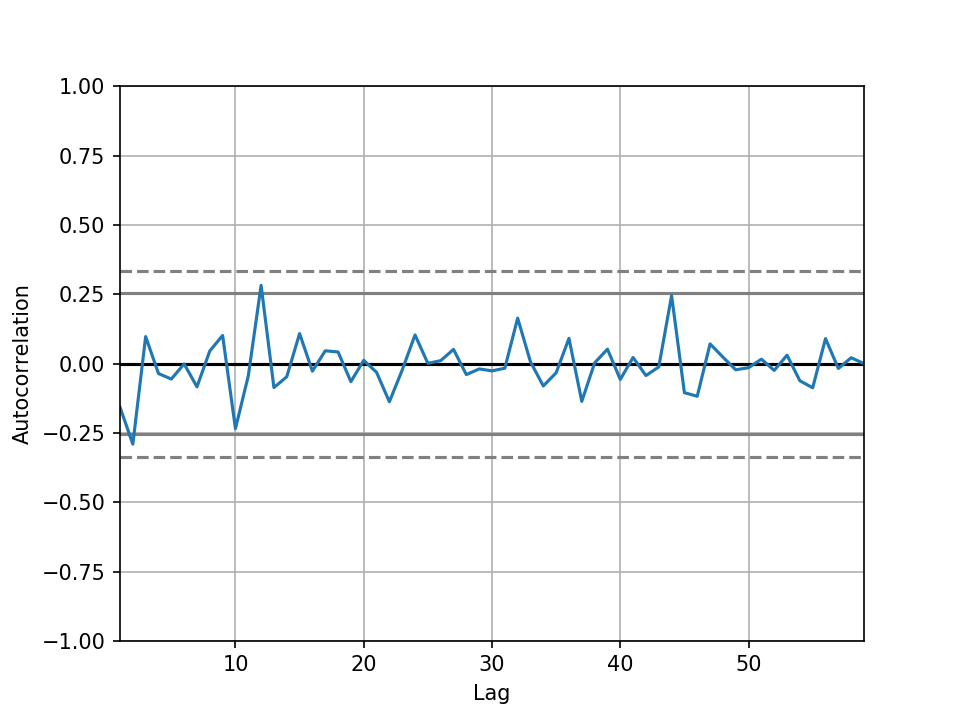

In [45]:
plt.figure()
spacing = np.linspace(-9 * np.pi, 9 * np.pi, num=1000)
autocorrelation_plot(diff_train_jitomate)


After looking at the autocorrelation plot, we can conclude that the series is random since all the values are inside the limits.

##### Autocorrelation plot for logarithmic data

<IPython.core.display.Javascript object>


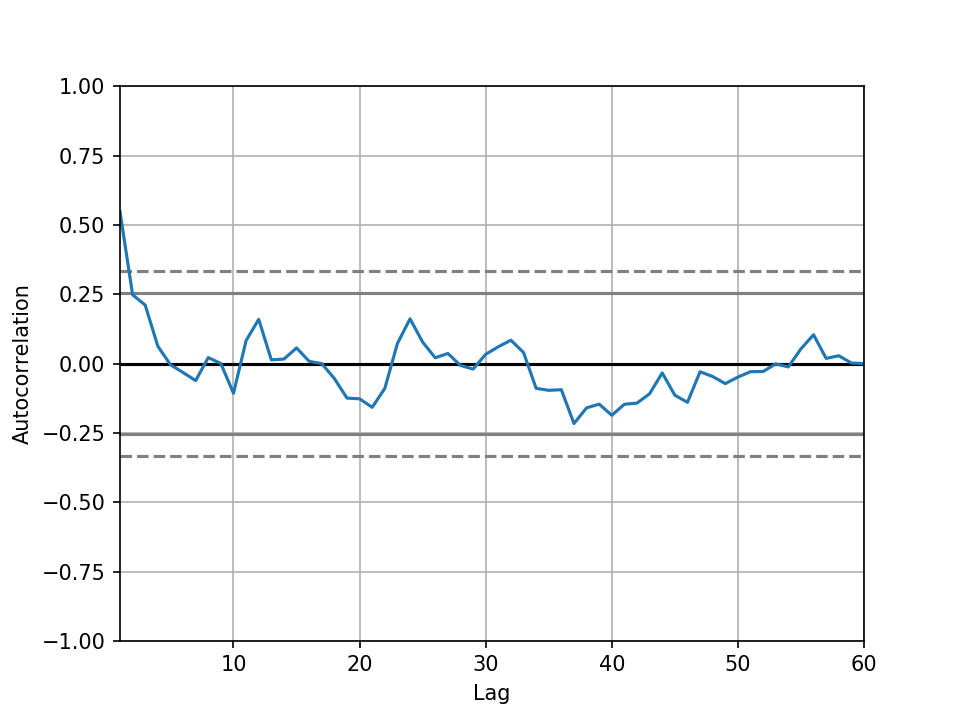

In [46]:
plt.figure()
spacing = np.linspace(-9 * np.pi, 9 * np.pi, num=1000)
autocorrelation_plot(log_train_jitomate)


For the logarithmic dataset only the first lag are significant. We will keep working with the differentiated dataset for the model.

#### Fit the model

###### ARIMA p=3, d=1, q=1

In [47]:
model = ARIMA(diff_train_jitomate, order = (3,1,1))

C:\Users\Nancy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Nancy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [48]:
model_fit = model.fit()

                             ARIMA Model Results                              
Dep. Variable:      D.Precio promedio   No. Observations:                   58
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -161.293
Method:                       css-mle   S.D. of innovations              3.730
Date:                Fri, 09 Aug 2019   AIC                            334.586
Time:                        22:12:44   BIC                            346.949
Sample:                             1   HQIC                           339.402
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0151      0.018      0.825      0.413      -0.021       0.051
ar.L1.D.Precio promedio    -0.2326      0.142     -1.638      0.107      -0.511       0.046


<IPython.core.display.Javascript object>


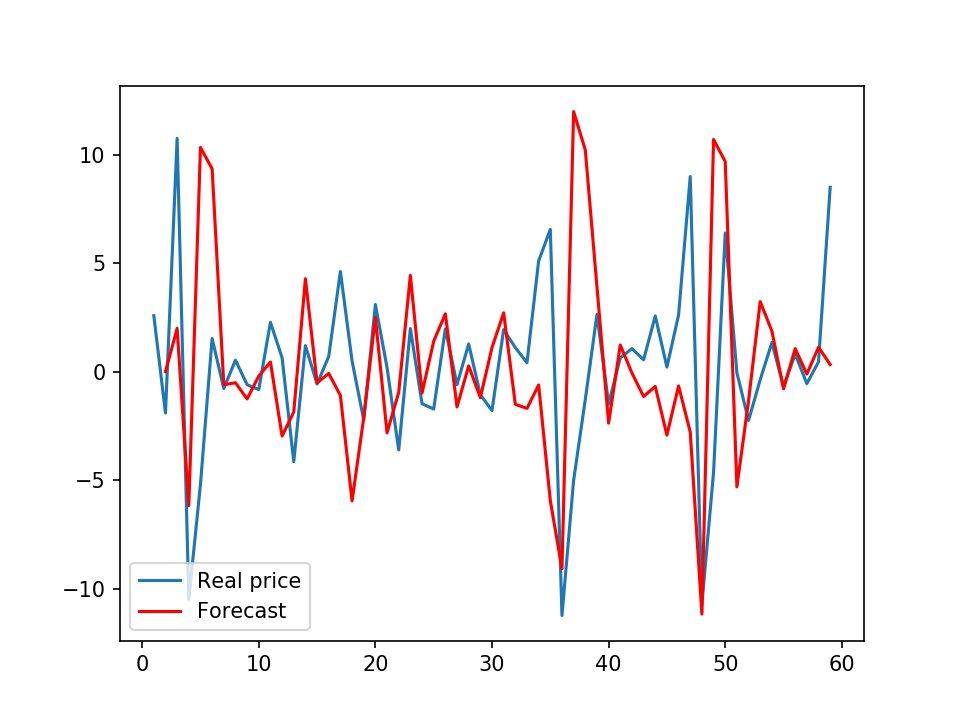

In [49]:
print(model_fit.summary())
plt.plot(diff_train_jitomate)
plt.plot(model_fit.fittedvalues, color='red')

ax = plt.gca()
ax.legend(['Real price', 'Forecast'])


As per the graph this model looks moreless, two of the four coefficients are statistically significant.

###### ARIMA p=1, d=1, q=1

In [50]:
model = ARIMA(diff_train_jitomate, order = (1,1,1))

C:\Users\Nancy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Nancy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [51]:
model_fit = model.fit()

                             ARIMA Model Results                              
Dep. Variable:      D.Precio promedio   No. Observations:                   58
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -164.577
Method:                       css-mle   S.D. of innovations              3.978
Date:                Fri, 09 Aug 2019   AIC                            337.153
Time:                        22:12:55   BIC                            345.395
Sample:                             1   HQIC                           340.364
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0175      0.027      0.661      0.511      -0.034       0.069
ar.L1.D.Precio promedio    -0.1561      0.134     -1.161      0.250      -0.419       0.107


<IPython.core.display.Javascript object>


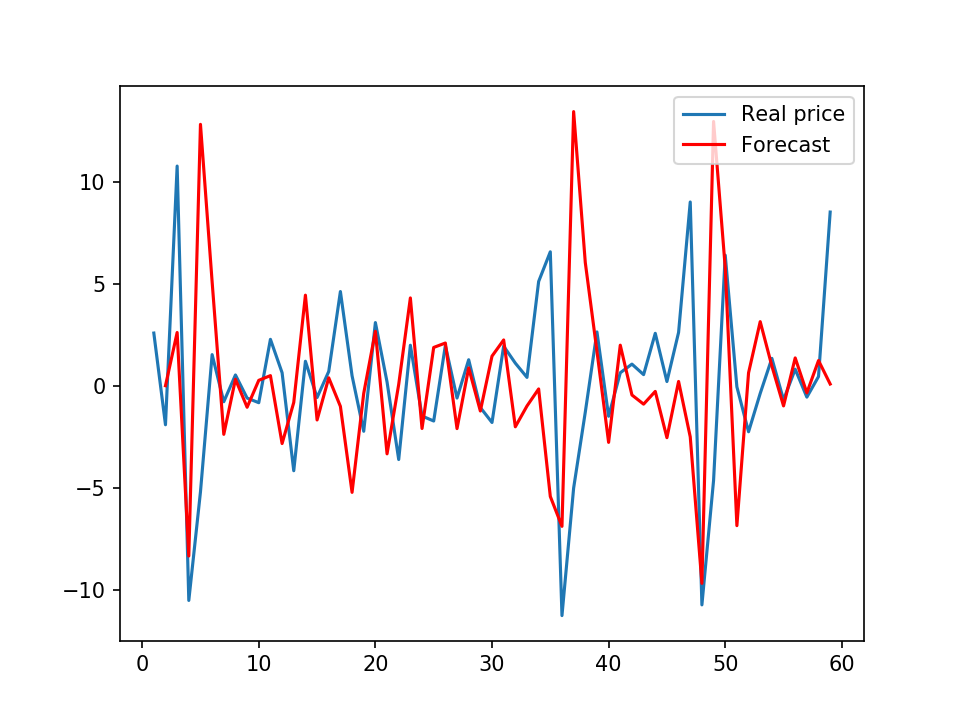

In [52]:
print(model_fit.summary())
plt.plot(diff_train_jitomate)
plt.plot(model_fit.fittedvalues, color='red')

ax = plt.gca()
ax.legend(['Real price', 'Forecast'])


This graph looks similar to the previous model however only the average mean coefficient is significant.

###### ARIMA p=3, d=1, q=2

In [53]:
model = ARIMA(diff_train_jitomate, order = (3,1,2))

C:\Users\Nancy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Nancy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [54]:
model_fit = model.fit()

                             ARIMA Model Results                              
Dep. Variable:      D.Precio promedio   No. Observations:                   58
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -161.235
Method:                       css-mle   S.D. of innovations              3.730
Date:                Fri, 09 Aug 2019   AIC                            336.471
Time:                        22:13:04   BIC                            350.894
Sample:                             1   HQIC                           342.089
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0146      0.019      0.748      0.458      -0.024       0.053
ar.L1.D.Precio promedio    -0.9150      0.654     -1.400      0.168      -2.196       0.366


<IPython.core.display.Javascript object>


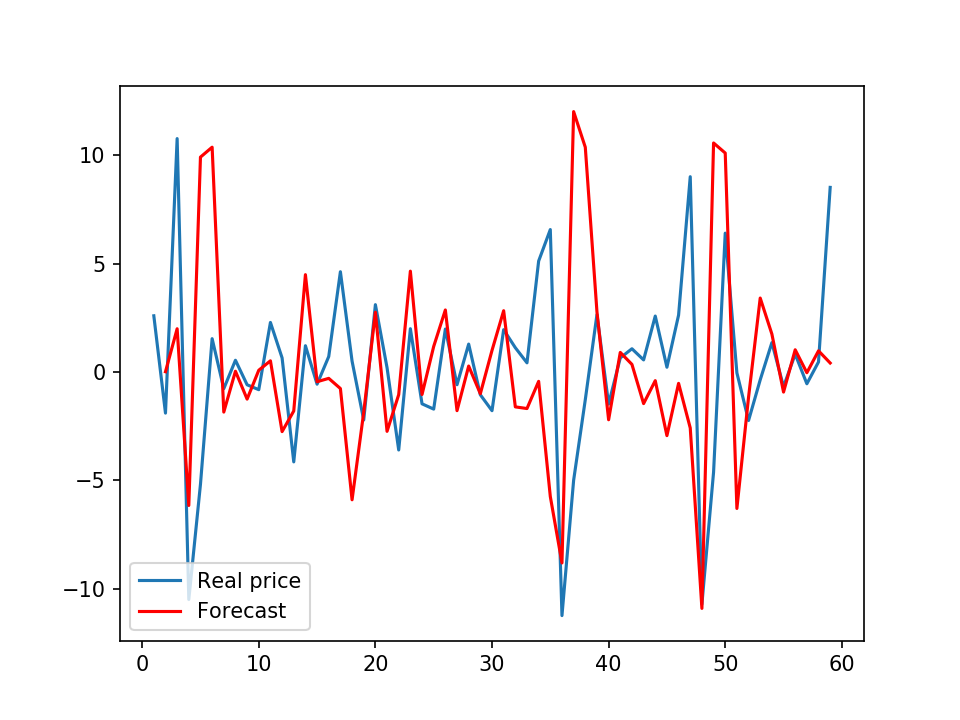

In [55]:
print(model_fit.summary())
plt.plot(diff_train_jitomate)
plt.plot(model_fit.fittedvalues, color='red')

ax = plt.gca()
ax.legend(['Real price', 'Forecast'])


Only one of the autorregressive coefficients is significant. 
<br>The model we are going to keep is the ARIMA(3,1,1) since it looks better.

#### Test the model ARIMA (3,1,1) and estimating more data

Let's see how good is our model by predicting data and matching it against test data. For testing we will use the original series without transformation.

predicted=24.148129, expected=25.921667
predicted=23.314836, expected=20.222593
predicted=21.902210, expected=19.522963
predicted=21.702192, expected=15.989815
predicted=16.738288, expected=13.647593
predicted=15.254194, expected=13.747037
predicted=14.162985, expected=14.339074
predicted=14.248188, expected=14.798148
predicted=14.515695, expected=20.742407
predicted=19.916898, expected=21.365185
predicted=19.471118, expected=23.584630
predicted=23.805872, expected=23.471481
predicted=22.727749, expected=14.992407
predicted=16.592271, expected=11.457963
predicted=14.065606, expected=12.882963
predicted=13.122188, expected=15.719815
predicted=15.132822, expected=20.015556
predicted=19.060389, expected=22.511667
predicted=21.489737, expected=27.668519
predicted=27.411551, expected=29.307963
predicted=28.189246, expected=22.966111
predicted=23.401388, expected=16.178889
predicted=17.886159, expected=17.894074
predicted=19.400013, expected=26.784630
Test MSE: 17.79


<IPython.core.display.Javascript object>


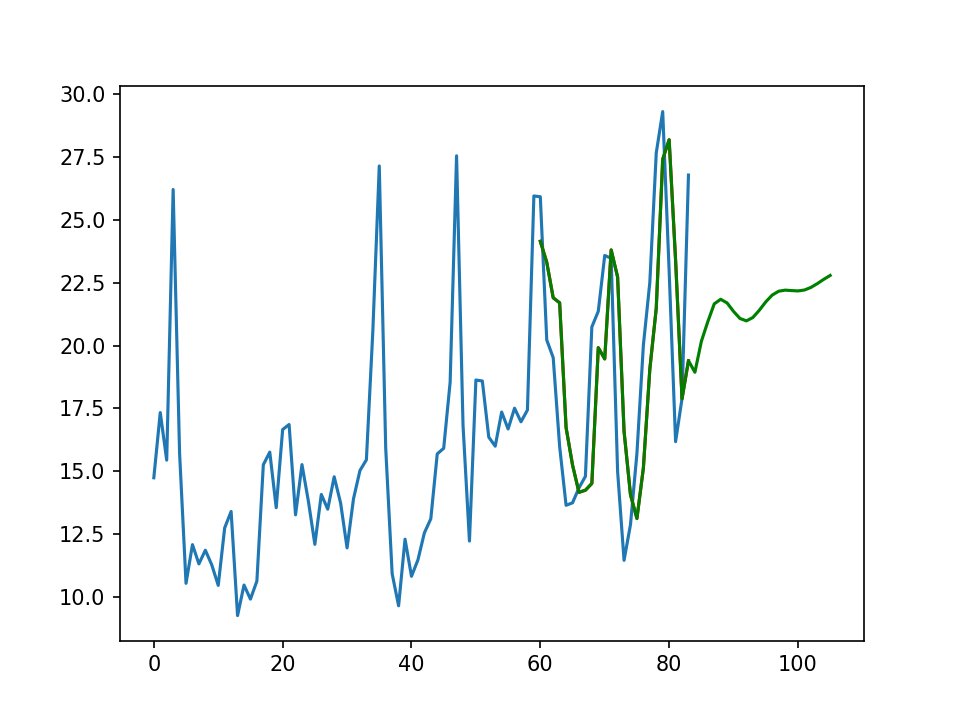

In [56]:
test_jitomate = test_jitomate.reset_index(drop=True)

#Test the model against train-datset
historical = [x for x in train_jitomate]
predictions = list()

for t in range(len(test_jitomate)):
    model = ARIMA(historical, order=(3,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_jitomate[t]
    historical.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_jitomate, predictions)
print('Test MSE: %.2f' % error)

# Future predictions beyond test-dataset
predictions2= predictions.copy()
start=84
end = 106

for t in np.arange(start,end):
    model = ARIMA(predictions2, order=(3,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(1)
    yhat = output[0]
    predictions2.append(yhat)

%matplotlib notebook
jitomatep = jitomatep.reset_index(drop=True)
predictions = pd.Series(predictions, index = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])
predictions2 = pd.Series(predictions2, index = np.arange(60,end))

plt.plot(jitomatep)
plt.plot(predictions, color='red')
plt.plot(predictions2, color='green')
plt.show()


#### Full list of predictions from jan-2016 to oct-2019

In [57]:
predictions2

60      [24.14812896618752]
61     [23.314835570344606]
62     [21.902210421617596]
63     [21.702191946977734]
64      [16.73828795739946]
65      [15.25419365181551]
66     [14.162984534245595]
67     [14.248188002553219]
68     [14.515694551417589]
69     [19.916898014513166]
70     [19.471118141809576]
71      [23.80587193198415]
72     [22.727748770709418]
73     [16.592270763768305]
74     [14.065606220729025]
75     [13.122187517491403]
76     [15.132822435202968]
77     [19.060389422825256]
78     [21.489737323294044]
79     [27.411550664715293]
80     [28.189245738909033]
81      [23.40138824122937]
82     [17.886159439875563]
83     [19.400012583206383]
84     [18.939743789398175]
85      [20.16739381446697]
86      [20.95029714400857]
87      [21.66008383485504]
88     [21.842559262926155]
89     [21.695448679814433]
90     [21.359588594556964]
91     [21.077713486689234]
92     [20.984841742737927]
93      [21.11769921840279]
94     [21.407337422390917]
95     [21.739677806

The plot looks fairly good as it follows the changes in price in a similar way but with a delay of one period. The mean squared error (MSE) is 17.79 meaning that the estimated price can vary by 4.22MXN per kg. The predictions made outside the iterations and retrainment with the test-dataset are trying to follow the upward trend however they are failing to catch the ups and downs.